# GAN as Deterministic Transport (Zero-Noise, One-Step Reverse Diffusion)

This notebook supports the **Example / Exercise** in Chapter 9 (Unified View) by demonstrating a central idea:

> A GAN generator can be viewed as a **deterministic transport map** that pushes a simple prior (e.g., standard Gaussian noise) to a data distribution in **one step**.

We do **not** aim to build a production GAN with all engineering refinements.  
Instead, we build a minimal, reproducible experiment that isolates the *transport* viewpoint:

1. **Warm-up (closed form):** a *linear* generator exactly matches a Gaussian target by matching mean/covariance.
2. **Nonlinear transport:** a small neural generator is trained to match a **mixture of Gaussians** using an **Integral Probability Metric** (MMD) loss.
3. Diagnostics and figures are produced and saved into `figs/` for inclusion in LaTeX.

**Outputs saved to `figs/`:**
- `gan_transport_samples.png` — target vs generated samples (overlay)
- `gan_transport_arrows.png` — arrows showing the deterministic map on a subset of latent samples
- `gan_transport_training_curve.png` — loss curve during training


In [1]:
# Imports, reproducibility, and figure directory
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

SEED = 7
np.random.seed(SEED)
torch.manual_seed(SEED)

FIG_DIR = Path("figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## Part A. Warm-up: Linear generator matches Gaussian data (closed form)

Let the prior be $ z \sim \mathcal N(0, I_d) $ and define a linear generator
$$
x = G(z) = W z + b .
$$
Then $x \sim \mathcal N(b,\; WW^\top)$.  
If the target is $x \sim \mathcal N(\mu, \Sigma)$, one exact solution is:
$$
b = \mu,\qquad W = \Sigma^{1/2},
$$
where $\Sigma^{1/2}$ is any matrix square root (e.g., Cholesky).

This is the simplest explicit illustration of **deterministic transport**.


In [2]:
def sample_gaussian(n, mu, Sigma):
    d = mu.shape[0]
    L = np.linalg.cholesky(Sigma)
    z = np.random.randn(n, d)
    return z @ L.T + mu

def gaussian_transport_params(mu, Sigma):
    W = np.linalg.cholesky(Sigma)
    b = mu
    return W, b

mu = np.array([1.2, -0.6])
Sigma = np.array([[1.4, 0.8],
                  [0.8, 1.2]])

W, b = gaussian_transport_params(mu, Sigma)

n = 2000
z = np.random.randn(n, 2)
x_gen = z @ W.T + b
x_tgt = sample_gaussian(n, mu, Sigma)

print("Target mean:", x_tgt.mean(axis=0))
print("Gen mean   :", x_gen.mean(axis=0))
print("Target cov:\n", np.cov(x_tgt.T))
print("Gen cov:\n", np.cov(x_gen.T))


Target mean: [ 1.18814126 -0.62458653]
Gen mean   : [ 1.19408537 -0.62905961]
Target cov:
 [[1.38186372 0.80559833]
 [0.80559833 1.20916835]]
Gen cov:
 [[1.37404093 0.82103105]
 [0.82103105 1.21753529]]


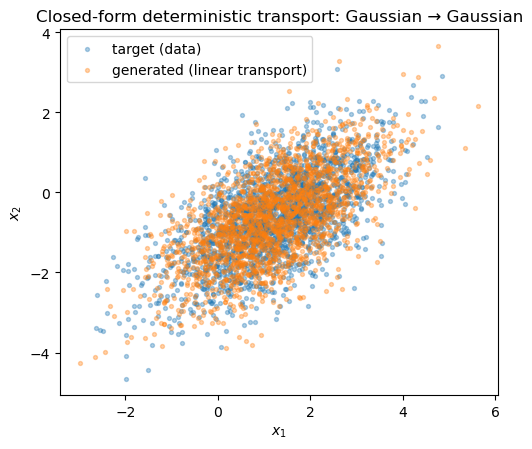

In [3]:
plt.figure(figsize=(5.2, 4.6))
plt.scatter(x_tgt[:,0], x_tgt[:,1], s=8, alpha=0.35, label="target (data)")
plt.scatter(x_gen[:,0], x_gen[:,1], s=8, alpha=0.35, label="generated (linear transport)")
plt.legend()
plt.title("Closed-form deterministic transport: Gaussian → Gaussian")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
plt.show()


## Part B. Nonlinear deterministic transport to a mixture of Gaussians

We now set the target to a **mixture of Gaussians** in 2D. A single affine map cannot match this distribution.

We learn a nonlinear generator $G_\theta$, trained via an IPM objective:
**Maximum Mean Discrepancy (MMD)** with an RBF kernel. This keeps training stable and short, while preserving
the key interpretation: *learn a deterministic pushforward map so the generated distribution matches data*.


In [4]:
def sample_gmm(n, means, covs, weights):
    k = len(weights)
    comps = np.random.choice(k, size=n, p=np.array(weights)/np.sum(weights))
    xs = []
    for i in range(k):
        ni = np.sum(comps == i)
        if ni == 0:
            continue
        xs.append(sample_gaussian(ni, means[i], covs[i]))
    return np.vstack(xs)

means = [
    np.array([-2.0, -1.5]),
    np.array([ 2.0, -1.0]),
    np.array([ 0.0,  2.2]),
]
covs = [
    np.array([[0.25, 0.05],[0.05, 0.35]]),
    np.array([[0.35,-0.08],[-0.08,0.25]]),
    np.array([[0.30, 0.00],[0.00, 0.30]]),
]
weights = [0.34, 0.33, 0.33]

n_data = 4096
x_data_np = sample_gmm(n_data, means, covs, weights).astype(np.float32)
x_data = torch.from_numpy(x_data_np).to(device)

x_data.shape


torch.Size([4096, 2])

In [5]:
class MLPGen(nn.Module):
    def __init__(self, d=2, h=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, h),
            nn.Tanh(),
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, d),
        )
    def forward(self, z):
        return self.net(z)

G = MLPGen(d=2, h=128).to(device)

def rbf_kernel(x, y, sigma):
    x_norm = (x**2).sum(dim=1, keepdim=True)
    y_norm = (y**2).sum(dim=1, keepdim=True).T
    dist2 = x_norm + y_norm - 2.0 * (x @ y.T)
    return torch.exp(-dist2 / (2.0 * sigma**2))

def mmd_rbf(x, y, sigma):
    Kxx = rbf_kernel(x, x, sigma)
    Kyy = rbf_kernel(y, y, sigma)
    Kxy = rbf_kernel(x, y, sigma)
    n = x.shape[0]
    m = y.shape[0]
    mmd = (Kxx.sum() - Kxx.diag().sum()) / (n*(n-1)) \
        + (Kyy.sum() - Kyy.diag().sum()) / (m*(m-1)) \
        - 2.0 * Kxy.mean()
    return mmd

batch = 512
steps = 1500
lr = 2e-3

opt = torch.optim.Adam(G.parameters(), lr=lr)

with torch.no_grad():
    x0 = x_data[torch.randperm(x_data.shape[0])[:512]]
    dists = torch.cdist(x0, x0)
    sigma = torch.median(dists).item()

sigma


3.512918710708618

In [6]:
loss_hist = []

for t in range(steps):
    idx = torch.randint(0, x_data.shape[0], (batch,), device=device)
    x = x_data[idx]
    z = torch.randn(batch, 2, device=device)

    xg = G(z)
    loss = mmd_rbf(xg, x, sigma=sigma)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    loss_hist.append(loss.item())
    if (t+1) % 250 == 0:
        print(f"step {t+1:4d}/{steps}, MMD={loss.item():.5f}")

len(loss_hist)


step  250/1500, MMD=-0.00022
step  500/1500, MMD=0.00035
step  750/1500, MMD=-0.00046
step 1000/1500, MMD=0.00484
step 1250/1500, MMD=0.00013
step 1500/1500, MMD=0.00179


1500

## Part C. Diagnostics and figures (saved to `figs/`)

We now generate:
1. an overlay of target and generated samples,
2. a visualization of determinism via arrows $z \mapsto G_\theta(z)$,
3. the training curve.


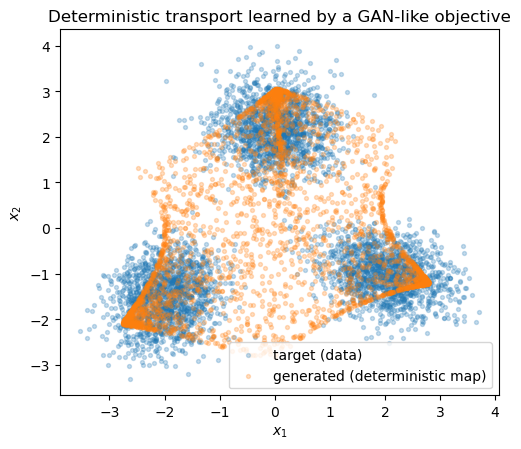

PosixPath('figs/gan_transport_samples.png')

In [10]:
with torch.no_grad():
    z_vis = torch.randn(3000, 2, device=device)
    x_gen = G(z_vis).cpu().numpy()

x_tgt = x_data.cpu().numpy()

plt.figure(figsize=(5.2, 4.6))
plt.scatter(x_tgt[:,0], x_tgt[:,1], s=8, alpha=0.25, label="target (data)")
plt.scatter(x_gen[:,0], x_gen[:,1], s=8, alpha=0.25, label="generated (deterministic map)")
plt.legend()
plt.title("Deterministic transport learned by a GAN-like objective")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
out1 = FIG_DIR / "gan_transport_samples.png"
plt.savefig(out1, dpi=200)
plt.show()

out1


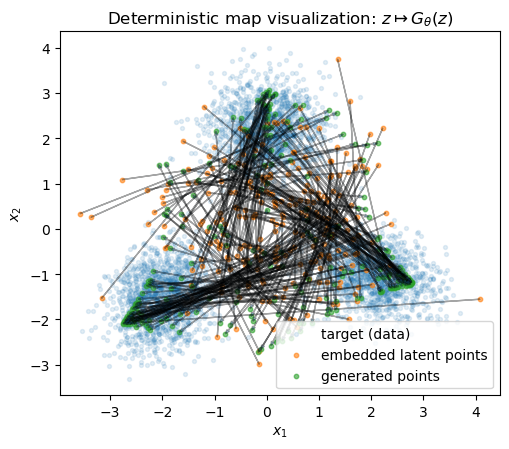

PosixPath('figs/gan_transport_arrows.png')

In [8]:
with torch.no_grad():
    z0 = torch.randn(250, 2, device=device)
    x0 = G(z0)
z0n = z0.cpu().numpy()
x0n = x0.cpu().numpy()

plt.figure(figsize=(5.2, 4.6))
plt.scatter(x_tgt[:,0], x_tgt[:,1], s=8, alpha=0.12, label="target (data)")

# Embed latent points into x-plane for a single-plot arrow visualization
z_embed = 1.2 * z0n
start = z_embed
end = x0n

plt.scatter(start[:,0], start[:,1], s=10, alpha=0.6, label="embedded latent points")
plt.scatter(end[:,0], end[:,1], s=10, alpha=0.6, label="generated points")
for i in range(start.shape[0]):
    plt.arrow(start[i,0], start[i,1],
              end[i,0]-start[i,0], end[i,1]-start[i,1],
              length_includes_head=True, head_width=0.06, alpha=0.35)

plt.legend(loc="best")
plt.title("Deterministic map visualization: $z \\mapsto G_\\theta(z)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
out2 = FIG_DIR / "gan_transport_arrows.png"
plt.savefig(out2, dpi=200)
plt.show()

out2


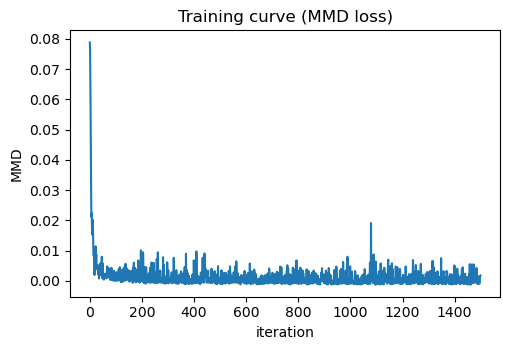

PosixPath('figs/gan_transport_training_curve.png')

In [9]:
plt.figure(figsize=(5.2, 3.6))
plt.plot(np.arange(len(loss_hist)), loss_hist)
plt.title("Training curve (MMD loss)")
plt.xlabel("iteration")
plt.ylabel("MMD")
plt.tight_layout()
out3 = FIG_DIR / "gan_transport_training_curve.png"
plt.savefig(out3, dpi=200)
plt.show()

out3


## Notes for the book text

- **`gan_transport_samples.png`**: shows that the generator implements a one-step deterministic map that matches a multi-modal distribution.
- **`gan_transport_arrows.png`**: emphasizes determinism: each latent point maps to exactly one output, unlike stochastic diffusion/bridge dynamics.
- **`gan_transport_training_curve.png`**: confirms convergence of the IPM objective.

This supports the conceptual claim:
> GAN-like training learns a deterministic transport map; diffusion models generalize this by adding time and stochastic exploration.


## Exercise prompts (to adapt into LaTeX)

1. Replace the 3-component mixture by a 4–5 component mixture and study stability / mode coverage.
2. Vary kernel bandwidth `sigma` and relate it to over-smoothing vs. mode dropping.
3. Replace MMD by a critic-based Wasserstein objective (WGAN-style) and compare.
4. (Advanced) Compare this deterministic map with a finite-noise Schrödinger bridge between the same endpoints.
